In [1]:
import os
import glob
import functools as ft
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from hmmlearn import hmm

## Set plotting parameters

In [2]:
mpl.rcParams.update({'pdf.fonttype': 42,
                     'ps.fonttype': 42,
                     'xtick.labelsize': 18,
                     'ytick.labelsize': 18, 
                     'axes.labelsize':18,
                     'font.size': 18})

## Upload the Repli-seq data

In [3]:
# the repli-seq data are from Dellino et al., 2013
path = r'./repli-seq/Dellino2013/deeptools/'
all_files = glob.glob(os.path.join(path , "*.bedGraph"))

dfs = []

for i, filename in enumerate(all_files):
    df = pd.read_csv(filename, sep = '\t', header = None, index_col = False)
    df.columns = ["chrom", "start", "end", f"S{i}"]
    df = df [(df.chrom != 'chrM') & (df.chrom != 'chrY')]
    dfs.append(df)
    
df_final = ft.reduce(lambda left, right: pd.merge(left, right, on=['chrom','start','end'], how='left'), dfs)
df_final = df_final.drop_duplicates(['chrom','start','end'])
df_final.dropna(inplace = True)
df_final

,chrom,start,end,S0,S1,S2,S3,S4,S5
0,chr1,0,50000,-0.733940,-0.034461,0.612460,0.268444,-0.145488,-0.795857
1,chr1,50000,100000,-1.034000,0.207312,0.543859,0.282782,-0.424148,-0.894782
2,chr1,100000,150000,0.223455,0.681823,0.850604,0.469693,-0.191618,-0.443650
3,chr1,150000,200000,-0.232756,-0.021948,0.070350,-0.180133,-0.938586,-1.214250
4,chr1,200000,250000,-0.271484,0.324185,0.559317,0.268511,-0.479499,-0.835541
...,...,...,...,...,...,...,...,...,...
57025,chrX,155000000,155050000,-1.079980,-0.628126,0.087571,0.208655,0.045926,-0.823424
57026,chrX,155050000,155100000,-0.724857,-0.638234,-0.035306,0.306479,-0.316973,-0.665632
57027,chrX,155100000,155150000,-0.950276,-0.290657,0.112241,0.229828,0.094687,-0.723975
57028,chrX,155150000,155200000,-1.371700,-0.593548,0.107713,0.251813,-0.169051,-0.627834


## Build the HMM model 

In [4]:
np.random.seed(42)

In [5]:
# Use the repli-seq values for each timepoint as the observed measurements X.
X = df_final[['S0', 'S1', 'S2', 'S3', 'S4', 'S5']].values

In [6]:
# Build the HMM model and fit to the repli-seq data.
# My six repli-seq datasets are six consecutive S-phase cell populations with BrdU-labeled DNA. 
# Hence I will fit the repli-seq values to a Gaussian emissions model with 6 hidden states. 
model = hmm.GaussianHMM(n_components=6,
                        covariance_type = "diag",
                        n_iter = 50,
                        random_state = 42,
                        init_params="mcs")
# I next defined the starting probabilities and transition matrix based on the knowledge of the repli-seq method. 
# States have the same starting probabilities
model.startprob_ = np.array([1/6, 1/6, 1/6, 1/6, 1/6, 1/6])
# Early replicating state 
model.transmat_ = np.array([[0.5, 0.5, 0., 0., 0., 0.],
                            [1/3, 1/3, 1/3, 0., 0., 0.],
                            [0., 1/3, 1/3, 1/3, 0., 0.],
                           [0., 0., 1/3, 1/3, 1/3, 0.],
                           [0., 0., 0., 1/3, 1/3, 1/3],
                           [0., 0., 0., 0., 0.5, 0.5]])
model.fit(X)

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
/users/sofia.kolesnikova/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


GaussianHMM(init_params='mcs', n_components=6, n_iter=50, random_state=42)

In [7]:
# Predict the hidden states corresponding to observed X
Z = model.predict(X)
states = pd.unique(Z)
print (states)

[3 4 5 2 1 0]


In [8]:
# add the predicted states to the initial repli-seq data
df_final ['state'] = Z

## Visualize the results

Text(0.5, 0, 'Position on chromosome 1, kbs')

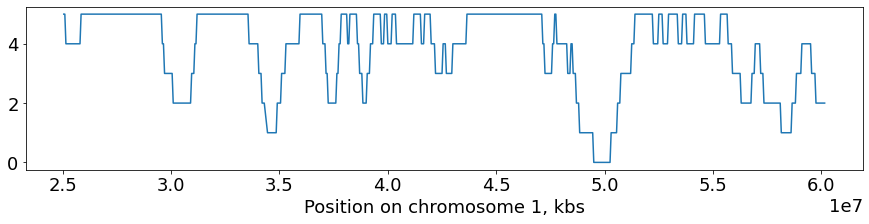

In [9]:
# plot a track of state changes along a subset of genome 
f, ax = plt.subplots(
    figsize=(15, 3))
plt.plot(
    df_final.start[500:1200],
    df_final.state[500:1200]);
ax.set_xlabel('Position on chromosome 1, kbs')

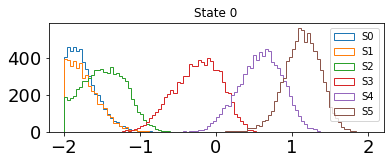

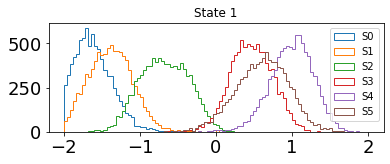

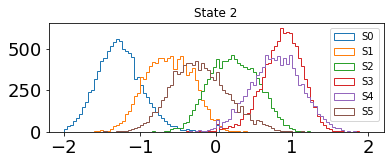

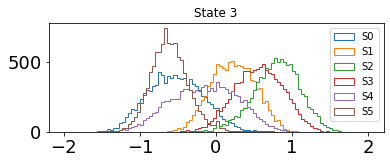

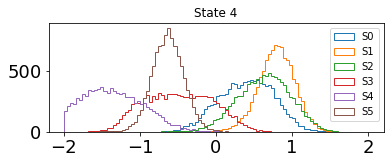

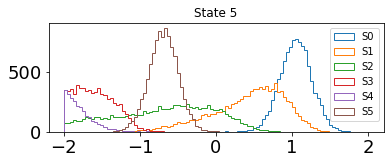

In [10]:
# plot the distibution of repli-seq signal for each state 
kws = dict(
    range=(-2,2),
    histtype='step',
    bins=100
)

for i in range(6):
    plt.figure(figsize=(6,2))
    for j in range(6):
        track = f'S{j}'
        plt.hist(
            df_final[df_final.state==i][track],
            label=track,
            **kws
            )
    plt.legend()
    plt.title(f'State {i}')

## Saving the states 

In [11]:
# states with higher values (5 and 6) apparently belong to early replicating regions, 
# while states with lower values (0 and 1) belong to late replicating regions. 
# This labelling is counter-intuituve and I will revert it before saving the files. 

In [12]:
mapping_dict = {}
keys = range(6)
for i, j in zip(keys, reversed(keys)):
    mapping_dict[i] = j

In [13]:
df_final["state"] = df_final['state'].map(mapping_dict)

In [14]:
#resDir = './repli-seq/Dellino2013/deeptools/hmm_output/'
#df_final.to_csv(os.path.join(resDir, f'repli-seq_hmm_states.bed'), sep = '\t', header = True, index = None)